<a href="https://colab.research.google.com/github/choijonghong/transformer/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

# 하이퍼파라미터 설정
epochs = 100
lr = 0.0002
batch_size = 128
latent_dim = 100  # 생성자에 입력될 랜덤 노이즈 벡터의 차원

# 결과 이미지를 저장할 디렉토리 생성
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

# MNIST 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(), # 이미지를 PyTorch 텐서로 변환
    transforms.Normalize((0.5,), (0.5,)) # 픽셀 값을 -1 ~ 1 사이로 정규화
])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


# 생성자 (Generator) 네트워크 정의
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 28 * 28), # MNIST 이미지 크기 (28x28)
            nn.Tanh() # 출력을 -1에서 1 사이로 조정
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28) # 이미지 형태로 reshape
        return img

# 판별자 (Discriminator) 네트워크 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid() # 출력을 0(가짜)과 1(진짜) 사이의 확률 값으로 조정
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1) # 이미지를 1차원으로 flatten
        validity = self.model(img_flat)
        return validity

# 모델, 손실 함수, 옵티마이저 초기화
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator().to(device)
discriminator = Discriminator().to(device)

# 손실 함수: 이진 교차 엔트로피 (Binary Cross-Entropy)
adversarial_loss = nn.BCELoss()

# 옵티마이저: Adam
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# --- 학습 루프 ---
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(train_loader):

        # 진짜(real)와 가짜(fake) 이미지에 대한 레이블 생성
        real_labels = torch.ones(imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(imgs.size(0), 1).to(device)

        # 진짜 이미지
        real_imgs = imgs.to(device)

        # ---------------------
        #  판별자(Discriminator) 학습
        # ---------------------
        optimizer_D.zero_grad()

        # 1. 진짜 이미지에 대한 손실 계산
        real_output = discriminator(real_imgs)
        d_loss_real = adversarial_loss(real_output, real_labels)

        # 2. 가짜 이미지 생성 및 손실 계산
        z = torch.randn(imgs.size(0), latent_dim).to(device) # 랜덤 노이즈
        fake_imgs = generator(z)
        fake_output = discriminator(fake_imgs.detach()) # generator의 그래디언트 흐름 차단
        d_loss_fake = adversarial_loss(fake_output, fake_labels)

        # 3. 전체 손실을 합산하고 역전파
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  생성자(Generator) 학습
        # -----------------
        optimizer_G.zero_grad()

        # 생성된 가짜 이미지를 판별자가 '진짜'로 판단하도록 학습
        fake_output = discriminator(fake_imgs)
        g_loss = adversarial_loss(fake_output, real_labels)

        g_loss.backward()
        optimizer_G.step()

    # 에포크마다 결과 출력 및 이미지 저장
    print(
        f"[Epoch {epoch+1}/{epochs}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]"
    )

    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_dim).to(device)
            generated_imgs = generator(z).cpu()

            fig, axes = plt.subplots(4, 4, figsize=(8, 8))
            for i, ax in enumerate(axes.flat):
                ax.imshow(generated_imgs[i].squeeze(), cmap='gray')
                ax.axis('off')

            plt.savefig(f"gan_images/{epoch+1}.png")
            plt.close()

100%|██████████| 9.91M/9.91M [00:00<00:00, 54.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.65MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.85MB/s]


[Epoch 1/100] [D loss: 0.1075] [G loss: 4.2031]
[Epoch 2/100] [D loss: 0.6260] [G loss: 2.6020]
[Epoch 3/100] [D loss: 0.6339] [G loss: 4.5600]
[Epoch 4/100] [D loss: 0.1166] [G loss: 4.1180]
[Epoch 5/100] [D loss: 0.4350] [G loss: 7.2194]
[Epoch 6/100] [D loss: 0.3070] [G loss: 4.4785]
[Epoch 7/100] [D loss: 0.1758] [G loss: 9.8439]
[Epoch 8/100] [D loss: 0.0577] [G loss: 6.4031]
[Epoch 9/100] [D loss: 0.3846] [G loss: 9.3252]
[Epoch 10/100] [D loss: 0.5821] [G loss: 4.7850]
[Epoch 11/100] [D loss: 0.1175] [G loss: 3.6197]
[Epoch 12/100] [D loss: 0.3945] [G loss: 6.3142]
[Epoch 13/100] [D loss: 1.1560] [G loss: 2.7707]
[Epoch 14/100] [D loss: 0.3067] [G loss: 2.4424]
[Epoch 15/100] [D loss: 0.2355] [G loss: 3.1872]
[Epoch 16/100] [D loss: 0.4742] [G loss: 2.6831]
[Epoch 17/100] [D loss: 0.3659] [G loss: 2.4194]
[Epoch 18/100] [D loss: 0.4173] [G loss: 1.7666]
[Epoch 19/100] [D loss: 0.6593] [G loss: 1.2214]
[Epoch 20/100] [D loss: 0.6194] [G loss: 1.5093]
[Epoch 21/100] [D loss: 0.432

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51004 (\N{HANGUL SYLLABLE EU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/pyt

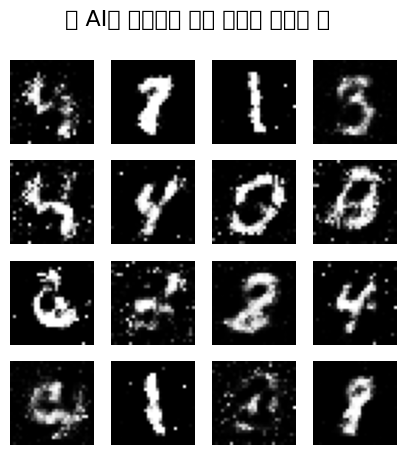

In [ ]:
# 이 셀을 실행할 때마다 새로운 숫자 이미지가 생성됩니다.

import tensorflow as tf
import matplotlib.pyplot as plt

# 1. 생성할 이미지 개수 설정 (원하는 만큼 바꾸세요)
num_images = 16

# 2. 새로운 무작위 노이즈(씨앗) 생성
new_noise = torch.randn(num_images, latent_dim).to(device)

# 3. 훈련된 생성자로 이미지 만들기
generated_images = generator(new_noise).cpu()

# 4. 결과 보여주기
plt.figure(figsize=(5, 5))
for i in range(num_images):
    plt.subplot(4, 4, i+1)
    # 픽셀 값을 원래대로 되돌려 이미지 표시
    ax = plt.gca()
    ax.imshow(generated_images[i].squeeze().detach().numpy(), cmap='gray')
    ax.axis('off')

plt.suptitle("✨ AI가 상상으로 그린 새로운 숫자들 ✨", fontsize=16)
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49707 (\N{HANGUL SYLLABLE SUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49696 (\N{HANGUL SYLLABLE SUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/pyth

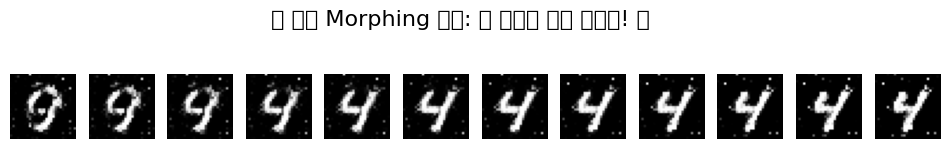

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# 1. '시작'과 '끝'이 될 두 개의 무작위 노이즈(설계도)를 준비합니다.
# (결과가 마음에 들지 않으면 이 셀을 다시 실행해서 다른 노이즈로 시도해보세요)
noise_A = torch.randn([1, latent_dim]).to(device)
noise_B = torch.randn([1, latent_dim]).to(device)

# 2. 두 노이즈 사이를 12단계로 나누어 중간 과정을 만듭니다.
num_steps = 12
interpolated_images = []
for i in range(num_steps):
    # alpha가 0이면 A, 1이면 B에 가까워집니다.
    alpha = i / (num_steps - 1)
    interpolated_noise = noise_A * (1 - alpha) + noise_B * alpha

    # 중간 설계도로 이미지 생성
    image = generator(interpolated_noise)
    interpolated_images.append(image[0])

# 3. 변화 과정 보여주기
plt.figure(figsize=(12, 2))
for i, image in enumerate(interpolated_images):
    plt.subplot(1, num_steps, i+1)
    plt.imshow(image[0].detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.suptitle("🚀 숫자 Morphing 마술: 한 숫자가 다른 숫자로! 🚀", fontsize=16)
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3

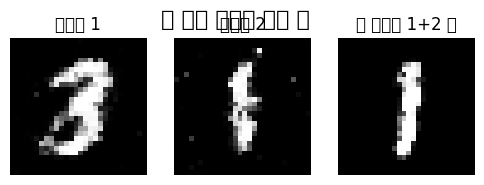

In [ ]:
import torch
import matplotlib.pyplot as plt

# 1. '재료'가 될 두 개의 서로 다른 스타일 노이즈를 준비합니다.
# (결과가 마음에 들지 않으면 이 셀을 다시 실행해서 다른 노이즈로 시도해보세요)
style_noise_1 = torch.randn([1, latent_dim]).to(device)
style_noise_2 = torch.randn([1, latent_dim]).to(device)

# 2. 두 스타일을 섞어 새로운 '조합' 노이즈를 만듭니다.
#    곱하는 숫자를 바꿔보며 스타일이 어떻게 변하는지 실험해보세요!
combined_noise = style_noise_1 + (style_noise_2 * 0.7)

# 3. 각 노이즈로 이미지를 생성합니다.
# Set the generator to evaluation mode
generator.eval()
with torch.no_grad():
  image_1 = generator(style_noise_1)
  image_2 = generator(style_noise_2)
  image_combined = generator(combined_noise)

# 4. 결과 비교하기
plt.figure(figsize=(6, 2))
plt.subplot(1, 3, 1)
plt.imshow(image_1[0].squeeze().cpu().numpy(), cmap='gray')
plt.title("스타일 1")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_2[0].squeeze().cpu().numpy(), cmap='gray')
plt.title("스타일 2")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_combined[0].squeeze().cpu().numpy(), cmap='gray')
plt.title("✨ 스타일 1+2 ✨")
plt.axis('off')

plt.suptitle("🎨 숫자 스타일 섞기 🎨", fontsize=16)
plt.show()